# Homework 4 - Evaluation

## Imports

In [109]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold

from tqdm.auto import tqdm

## Data Preparation

In [110]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [111]:
# Divide columns into categorical and numerical variables
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

# Replace missing valaues
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)

# 60/20/20 split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset indeces
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Create y variables from converted
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

# Remove converted from datasets
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [112]:
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,0.0,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NA,5,71016.0,self_employed,north_america,0,0.25,1


## Functions

In [113]:
# Applies one-hot-encoding before training with logisitc regression
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [114]:
# Applies scaling and one-hot-encoding before training with logisitc regression
def train_scaled(df_train, y_train, C=1.0):
    # Apply scaling to numerical features
    X_train_num = df_train[numerical].values
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)

    # Process categorical features with OHE
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_train_cat = ohe.fit_transform(df_train[categorical].values)

    # Merge to create full training matrix
    X_train = np.column_stack([X_train_num, X_train_cat])

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [115]:
# Makes a prediction for df based on the given model
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [116]:
# Cross validation function using k folds
def cross_validation(df, n=5, C=1.0):
    kfold = KFold(n_splits=n, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df):
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    return scores

## Question 1

In [117]:
roc_auc_score(y_train, df_train['lead_score'])

0.6144993577250176

In [118]:
roc_auc_score(y_train, df_train['number_of_courses_viewed'])

0.7635680590007088

In [119]:
roc_auc_score(y_train, df_train['interaction_count'])

0.738270176293409

In [120]:
roc_auc_score(y_train, df_train['annual_income'])

0.5519578313253012

'number_of_courses_viewed' has the highest AUC

## Question 2

In [121]:
# Unscaled trained model for future questions
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

In [122]:
# Scaled trained model for Q2
dv_s, model_s = train_scaled(df_train, y_train)
y_pred_s = predict(df_val, dv_s, model_s)
auc = roc_auc_score(y_val, y_pred_s)
round(auc, 3)

0.512

The AUC of the model on the validation set is approximately 0.52.

## Question 3

In [123]:
# Evaluate model on all thresholds
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [124]:
# Create a Confusion Table and evaluate precision and recall
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [125]:
df_scores[::10]

,threshold,tp,fp,fn,tn,p,r
0,0.0,171,122,0,0,0.583618,1.000000
10,0.1,171,122,0,0,0.583618,1.000000
20,0.2,171,122,0,0,0.583618,1.000000
30,0.3,171,119,0,3,0.589655,1.000000
40,0.4,171,105,0,17,0.619565,1.000000
50,0.5,164,81,7,41,0.669388,0.959064
60,0.6,150,53,21,69,0.738916,0.877193
70,0.7,106,25,65,97,0.809160,0.619883
80,0.8,64,6,107,116,0.914286,0.374269
90,0.9,24,1,147,121,0.960000,0.140351


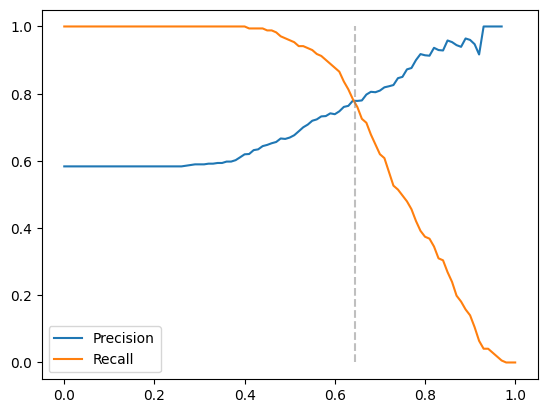

In [126]:
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')

plt.vlines(0.645, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

It is roughly close to intersecting at 0.745.

## Question 4

In [127]:
# Add a column to df_scores with the f1 value of each threshold
df_scores['f1'] = 2 * (df_scores['p'] * df_scores['r'] / (df_scores['p'] + df_scores['r']))
df_scores[['threshold', 'f1']]

,threshold,f1
0,0.00,0.737069
1,0.01,0.737069
2,0.02,0.737069
3,0.03,0.737069
4,0.04,0.737069
...,...,...
96,0.96,0.034483
97,0.97,0.011628
98,0.98,NaN
99,0.99,NaN


In [128]:
# Locate the index of the row with max f1 to find the corresponding threshold
max_f1_idx = df_scores.f1.idxmax()
max_f1_threshold = df_scores.iloc[max_f1_idx]
max_f1_threshold

threshold      0.570000
tp           156.000000
fp            57.000000
fn            15.000000
tn            65.000000
p              0.732394
r              0.912281
f1             0.812500
Name: 57, dtype: float64

Threshold 0.54 has the maximal F1 value.

## Question 5

In [129]:
scores = cross_validation(df_full_train)
np.std(scores)

np.float64(0.03580711942905165)

The standard deviation is approximately 0.06.

## Question 6

In [130]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = cross_validation(df_full_train, n_splits, C)

    print('C: %s  Score: %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C: 1e-06  Score: 0.560 +- 0.024
C: 0.001  Score: 0.867 +- 0.029
C: 1  Score: 0.822 +- 0.036


C=0.001 has the best mean score.